<a href="https://colab.research.google.com/github/anoushkagarg003/time_series_metro_dataset/blob/main/Arima_autoarima_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc

import warnings
warnings.filterwarnings('ignore')

In [50]:
data = pd.read_csv('/content/Metro_Interstate_Traffic_Volume.csv.gz', infer_datetime_format=True)

In [51]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [52]:
data.describe(include = 'all')

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
count,61,48204.000000,48204.000000,48204.000000,48204.000000,48204,48204,48204,48204.000000
unique,11,NaN,NaN,NaN,NaN,11,38,NaN,NaN
top,Labor Day,NaN,NaN,NaN,NaN,Clouds,sky is clear,NaN,NaN
freq,7,NaN,NaN,NaN,NaN,15164,11665,NaN,NaN
mean,NaN,281.205870,0.334264,0.000222,49.362231,NaN,NaN,2016-01-05 10:46:16.773711616,3259.818355
min,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,2012-10-02 09:00:00,0.000000
25%,NaN,272.160000,0.000000,0.000000,1.000000,NaN,NaN,2014-02-06 11:45:00,1193.000000
50%,NaN,282.450000,0.000000,0.000000,64.000000,NaN,NaN,2016-06-11 03:30:00,3380.000000
75%,NaN,291.806000,0.000000,0.000000,90.000000,NaN,NaN,2017-08-11 06:00:00,4933.000000
max,NaN,310.070000,9831.300000,0.510000,100.000000,NaN,NaN,2018-09-30 23:00:00,7280.000000


In [53]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [54]:
ts = data['2018-08-30':'2018-09-29']

In [55]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-08-30 00:00:00,NaN,286.24,0.25,0.0,1,Rain,light rain,2018-08-30 00:00:00,670
2018-08-30 01:00:00,NaN,285.53,0.25,0.0,1,Rain,light rain,2018-08-30 01:00:00,456
2018-08-30 02:00:00,NaN,285.35,0.25,0.0,1,Rain,light rain,2018-08-30 02:00:00,326
2018-08-30 03:00:00,NaN,285.33,0.25,0.0,1,Rain,light rain,2018-08-30 03:00:00,388
2018-08-30 04:00:00,NaN,285.49,0.25,0.0,1,Rain,light rain,2018-08-30 04:00:00,1008


In [56]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()
len(ts_train), len(ts_test)

(553, 191)

In [57]:
from statsmodels.tsa.stattools import adfuller
window = 24*7
cutoff = 0.05
def test_stationarity(timeseries, window = window, cutoff = cutoff):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(30, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 24 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

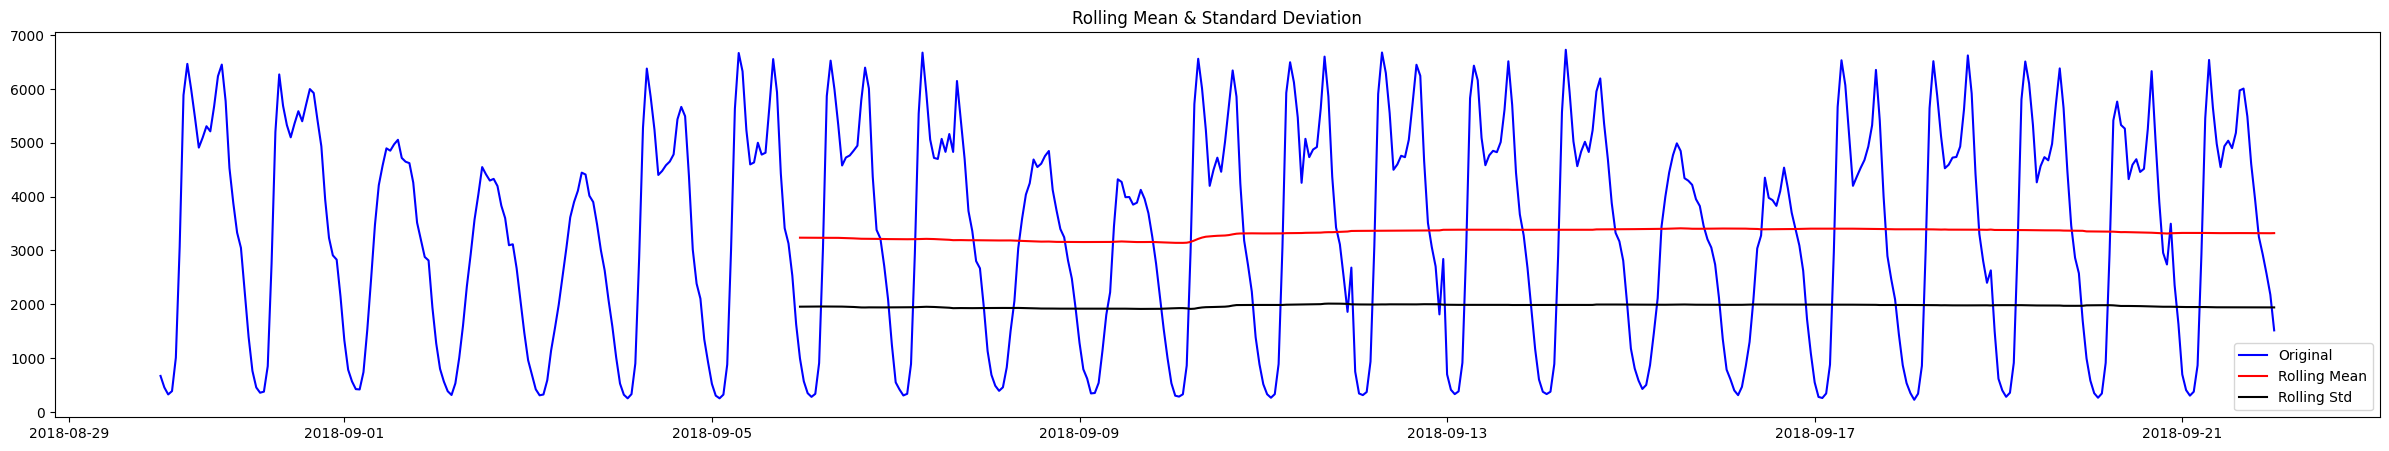

Results of Dickey-Fuller Test:
p-value = 0.0698. The series is likely non-stationary.
Test Statistic                  -2.725073
p-value                          0.069799
#Lags Used                      24.000000
Number of Observations Used    528.000000
Critical Value (1%)             -3.442796
Critical Value (5%)             -2.867030
Critical Value (10%)            -2.569694
dtype: float64


In [58]:
test_stationarity(ts_train.traffic_volume)

In [59]:
lag = 24
lag_pacf = pacf(ts_train.traffic_volume, nlags=lag, method='ols')
lag_acf = acf(ts_train.traffic_volume, nlags=lag)

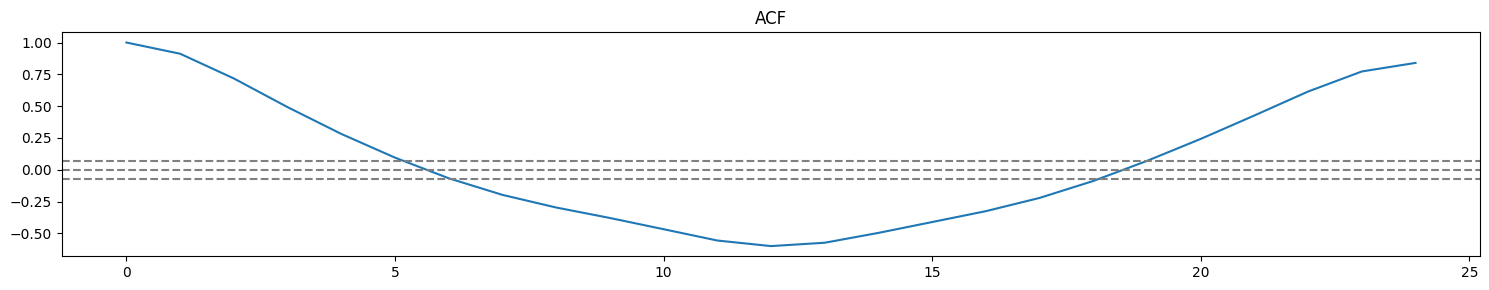

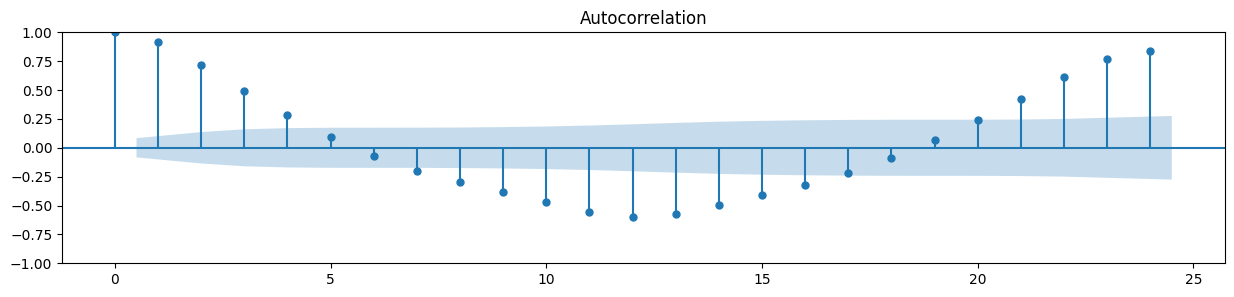

In [60]:
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train.traffic_volume, ax=plt.gca(),lags=lag)
plt.show()

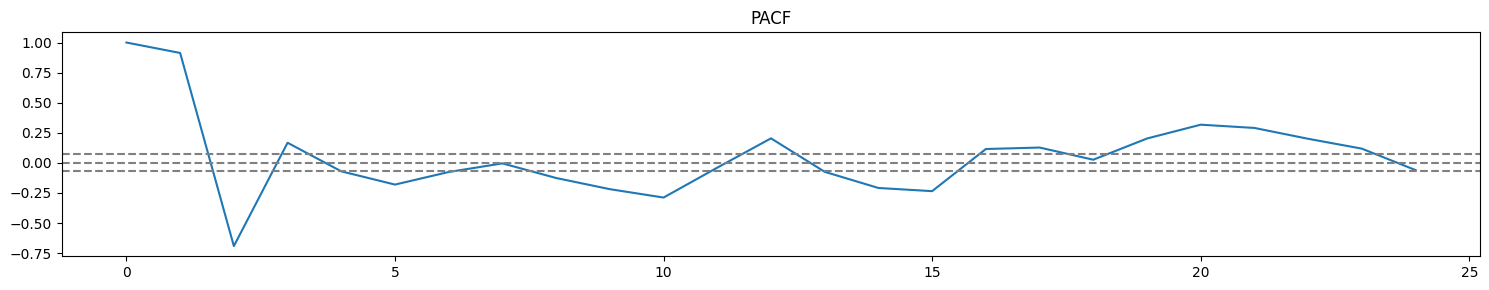

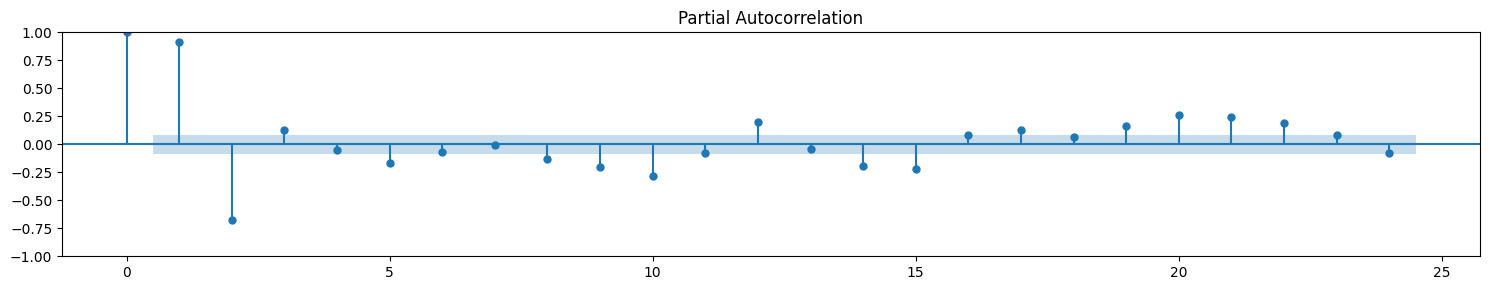

In [61]:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train.traffic_volume, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [62]:
p=2
d=0
q=1

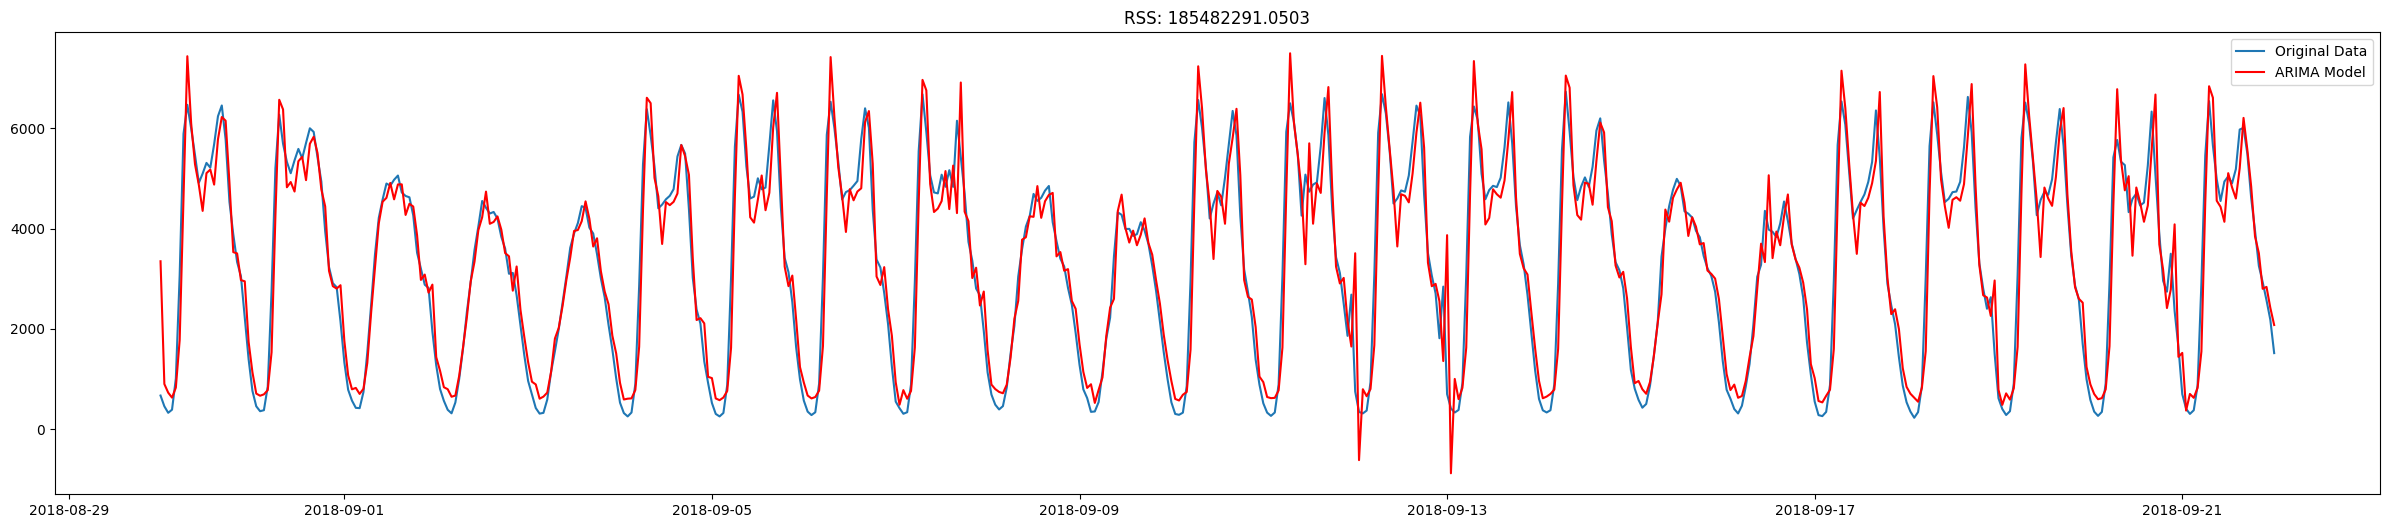

In [63]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_train['traffic_volume'], order=(p, d, q))
results_ARIMA = model.fit()

# Plot original data and fitted values
plt.figure(figsize=(30, 6))
plt.plot(ts_train.index, ts_train['traffic_volume'], label='Original Data')
plt.plot(ts_train.index, results_ARIMA.fittedvalues, color='red', label='ARIMA Model')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues - ts_train['traffic_volume'])**2))
plt.legend()
plt.show()

In [64]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                  553
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -4294.084
Date:                Thu, 11 Jul 2024   AIC                           8598.169
Time:                        06:31:49   BIC                           8619.746
Sample:                    08-30-2018   HQIC                          8606.599
                         - 09-22-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3346.8915    211.892     15.795      0.000    2931.590    3762.193
ar.L1          1.4305      0.049     29.370      0.000       1.335       1.526
ar.L2         -0.5860      0.048    -12.233      0.000      -0.680      -0.492
ma.L1          0.2318      0.058      3.978      0.000       0.118       0.346
sigma2      3.243e+05   1.48e+04     21.870      0.000    2.95e+05    3.53e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               194.70
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

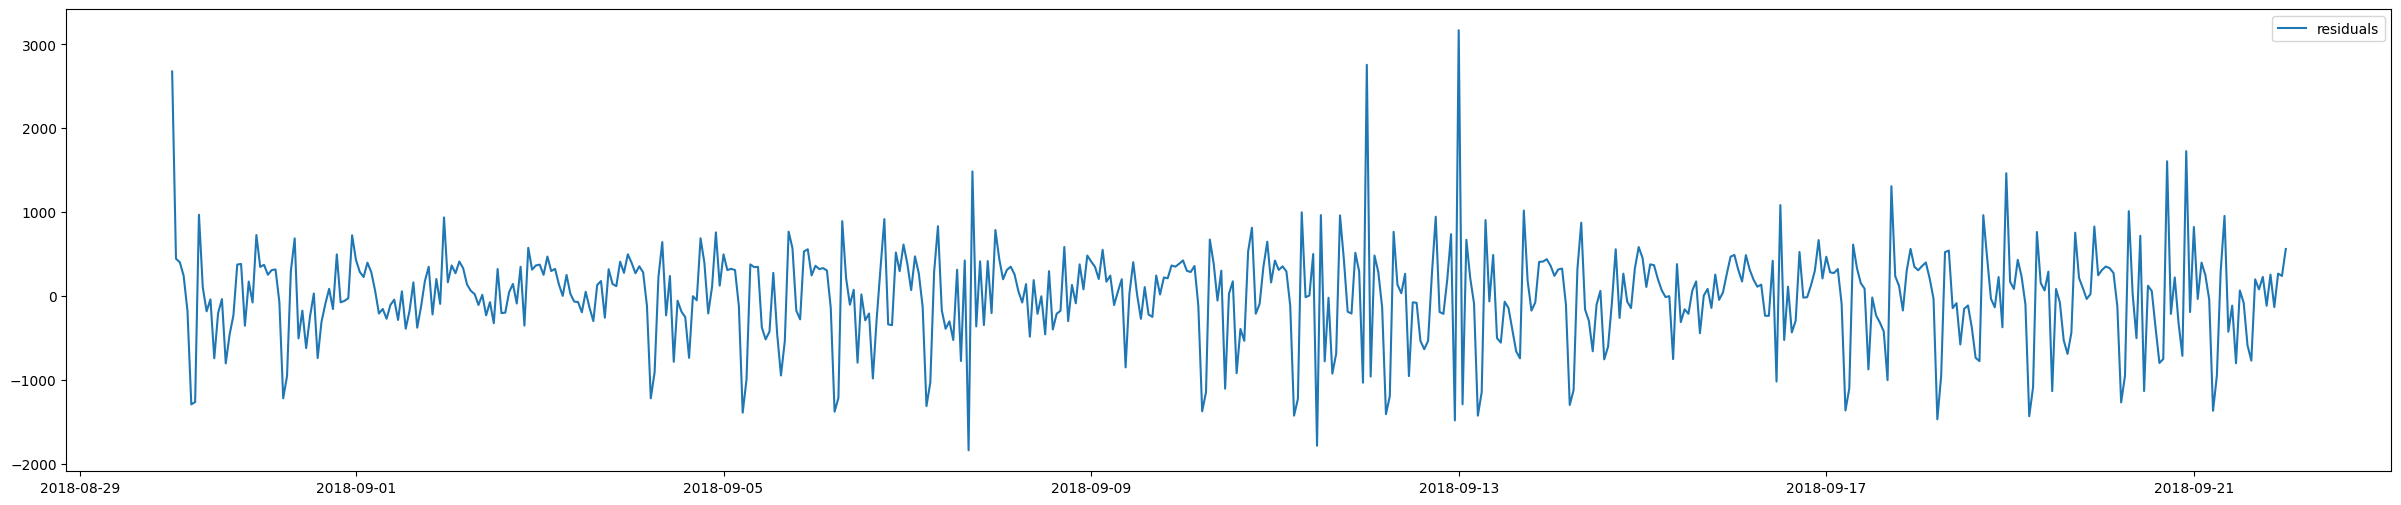

In [65]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train.traffic_volume
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

In [66]:
def StartARIMAForecasting(Actual, p, d, q):
    model = ARIMA(Actual, order=(p, d, q))
    model_fit = model.fit()
    prediction = model_fit.forecast()[0]
    return prediction

# Initialize lists for actual and predicted values
Actual = ts_train['traffic_volume'].tolist()
Predictions = []

# Forecasting loop
for timepoint in range(len(ts_test)):
    ActualValue = ts_test['traffic_volume'].iloc[timepoint]
    Prediction = StartARIMAForecasting(Actual, p, d, q)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    Predictions.append(Prediction)
    Actual.append(ActualValue)

# Convert predictions to DataFrame and set index
predictions = pd.DataFrame(Predictions, index=ts_test.index, columns=['predicted_traffic_volume'])
print(predictions)

Actual=1273.000000, Predicted=1282.372896
Actual=1207.000000, Predicted=1450.499736
Actual=611.000000, Predicted=1443.204571
Actual=647.000000, Predicted=489.347031
Actual=960.000000, Predicted=1118.963535
Actual=1635.000000, Predicted=1471.329721
Actual=2445.000000, Predicted=2328.668300
Actual=3415.000000, Predicted=3081.892807
Actual=3770.000000, Predicted=4046.719971
Actual=4308.000000, Predicted=3845.121492
Actual=4638.000000, Predicted=4577.674490
Actual=4831.000000, Predicted=4642.909437
Actual=4565.000000, Predicted=4755.404154
Actual=4654.000000, Predicted=4174.346288
Actual=4589.000000, Predicted=4611.845541
Actual=4582.000000, Predicted=4352.281955
Actual=4847.000000, Predicted=4438.450094
Actual=4620.000000, Predicted=4864.102060
Actual=4347.000000, Predicted=4234.431775
Actual=3602.000000, Predicted=4058.043502
Actual=2985.000000, Predicted=3020.844720
Actual=2480.000000, Predicted=2669.234939
Actual=1871.000000, Predicted=2272.734624
Actual=1249.000000, Predicted=1647.310

In [67]:
pip install pmdarima

In [72]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))

In [73]:
error_metrics(ts_test.traffic_volume, predictions)

Mean Absolute Error: 394.42
Root Mean Squared Error: 542.70


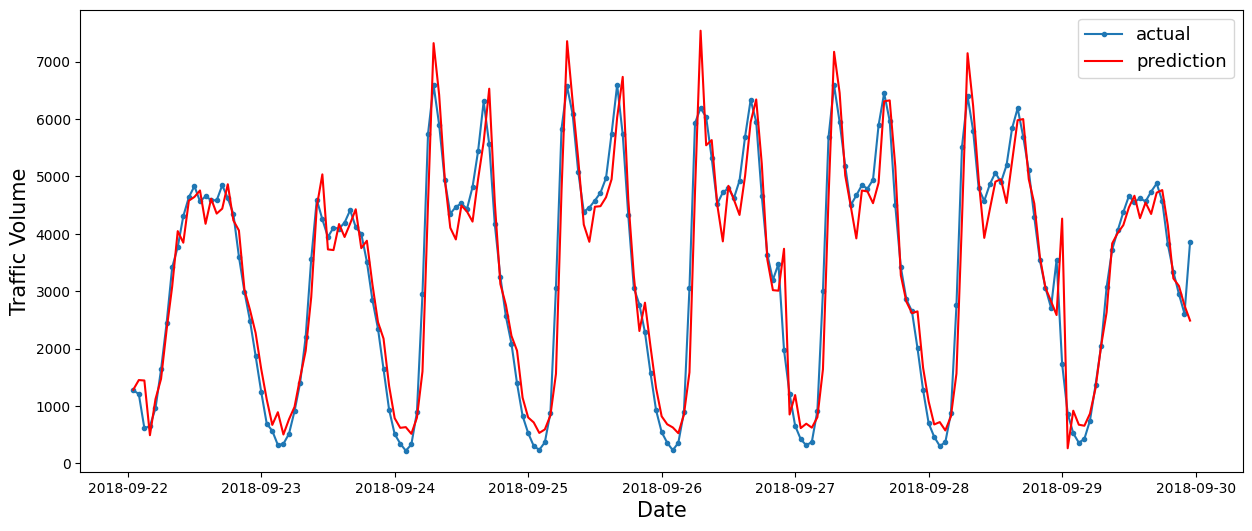

In [74]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions)[0], 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

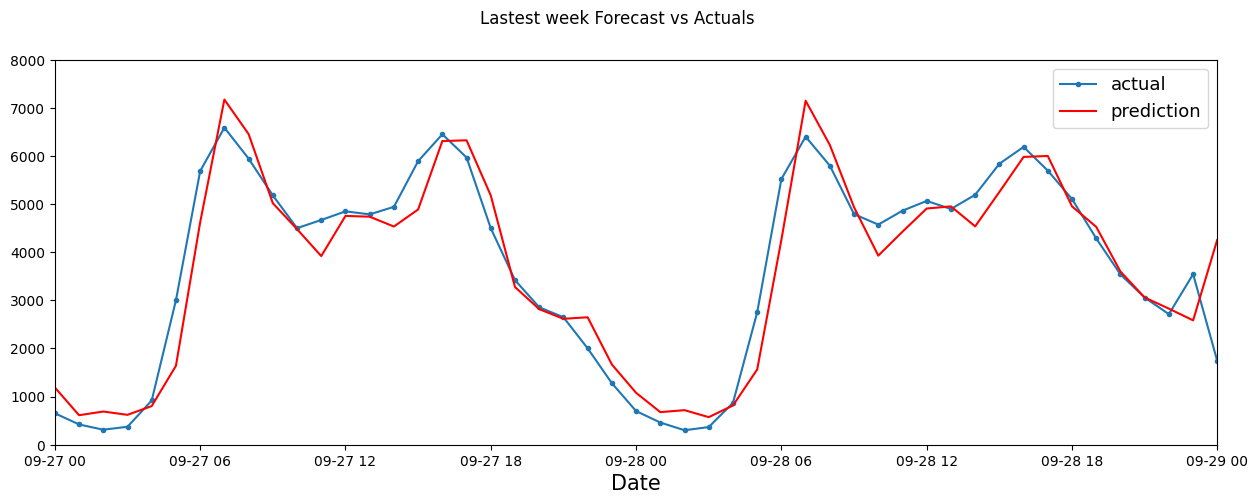

In [75]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions)[0], 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

In [76]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(ts_train.traffic_volume, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      max_P=3, max_Q=3,
                      m=24,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                     n_fits = 50)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=9963.607, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=8.05 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=8959.811, Time=2.76 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=10712.009, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=9345.111, Time=0.95 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=7.05 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=8837.609, Time=23.49 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=8824.436, Time=30.79 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=inf, Time=69.39 sec
 ARIMA(0,0,1)(1,0,3)[24] intercept   : AIC=8775.105, Time=77.96 sec
 ARIMA(0,0,1)(0,0,3)[24] intercept   : AIC=8782.450, Time=39.99 sec
 ARIMA(0,0,1)(2,0,3)[24] intercept   : AIC=inf, Time=68.16 sec
 ARIMA(0,0,0)(1,0,3)[24] intercept   : AIC=inf, Time=52.90 sec
 ARIMA(1,0,1)(1,0,3)[24] intercept   : AI

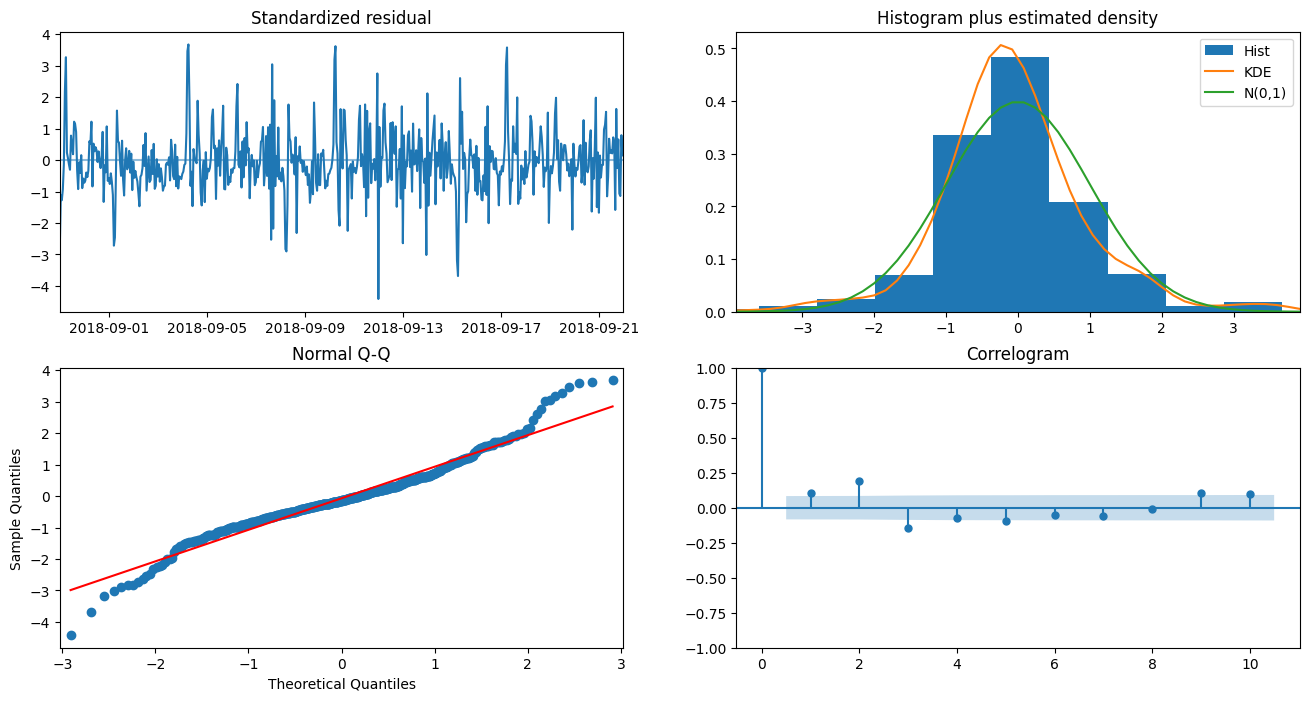

In [77]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [78]:
y_pred = model.predict(len(ts_test))

In [79]:
print('Test Mean Absolute Error:', mean_absolute_error(ts_test.traffic_volume, y_pred))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test.traffic_volume, y_pred)))

Test Mean Absolute Error: 1021.1138449583681
Test Root Mean Squared Error: 1337.5298134061136
Test Mean Absolute percentage Error: 114.57639159735228


In [80]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(ts_train.traffic_volume,order=(p,d,q),seasonal_order=(p,d,q, 24))
results=model.fit()

In [81]:
y_pred = pd.DataFrame(results.predict(len(ts_test)))

                                     SARIMAX Results                                      
Dep. Variable:                     traffic_volume   No. Observations:                  553
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 24)   Log Likelihood               -4172.201
Date:                            Thu, 11 Jul 2024   AIC                           8358.402
Time:                                    06:57:34   BIC                           8388.609
Sample:                                08-30-2018   HQIC                          8370.204
                                     - 09-22-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2291      0.051     23.914      0.000       1.128       1.330
ar.L2         -0.3532      0.053   

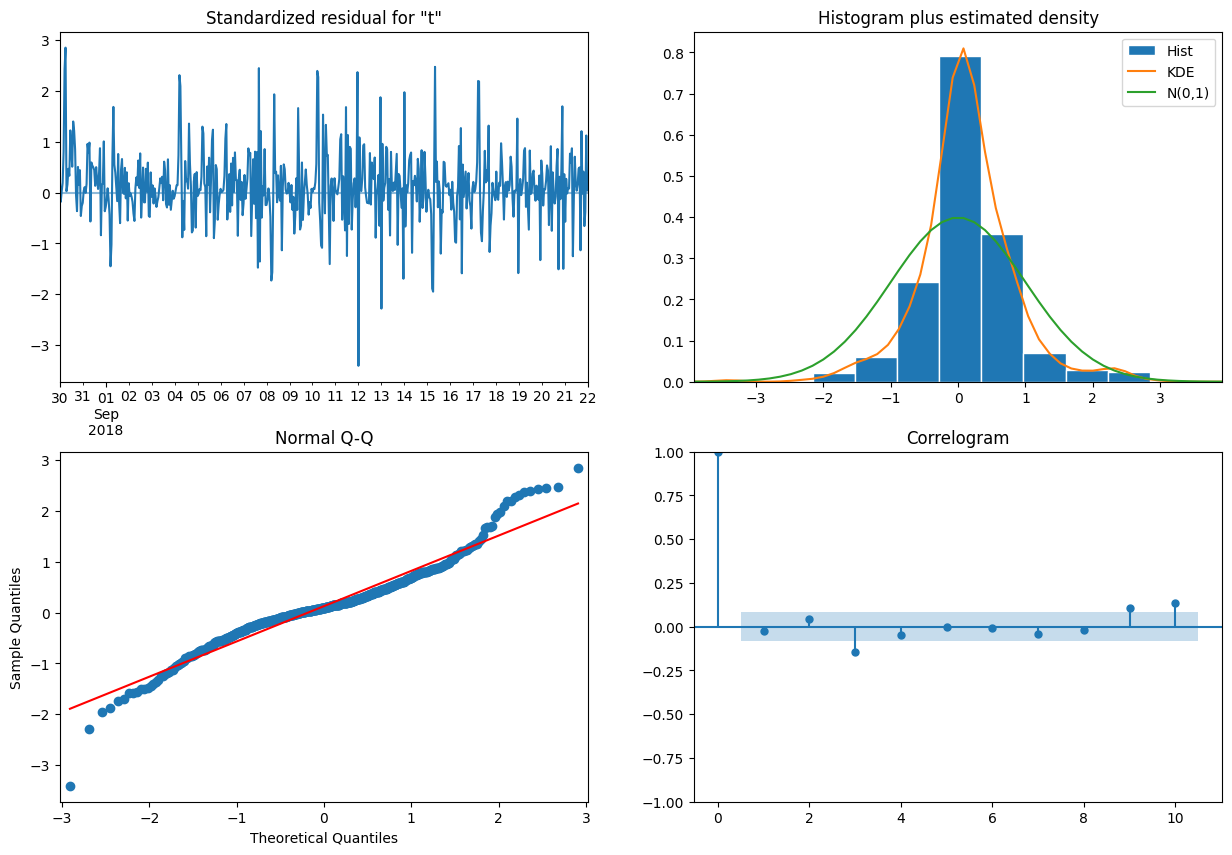

In [82]:
print(results.summary())
fitted_values = results.fittedvalues
residuals = results.resid
results.plot_diagnostics(figsize=(15, 10))
plt.show()